# Image segmentation using traditonal machine learning

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Get an example image and its labeled counterpart (ground truth)

We need to use a labeled image as ground truth. We can produce such a image by painting the relevant regions using Fiji, or other segmentation algorithms to automate the process (easier if you have only two classes).

Shapes: Original --> (512, 512)  Labeled -->  (512, 512)


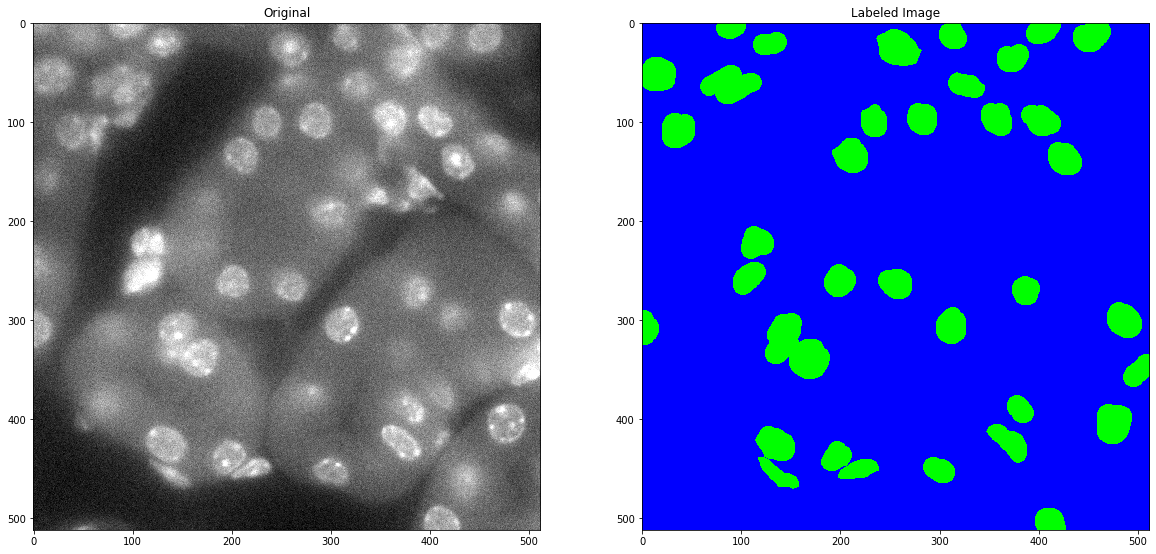

In [2]:
# import the images, both original and ground truth.
img = cv2.imread('images/nuclei/original.tif')
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
labeled_img = cv2.imread('images/nuclei/label.tif')
labeled_img_grayscale = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Original')

fig.add_subplot(1,2,2)
plt.imshow(labeled_img_grayscale, cmap='brg') 
plt.title('Labeled Image')

print('Shapes: Original -->',img_grayscale.shape, ' Labeled --> ', labeled_img_grayscale.shape)

### Step 2: Create feature bank

A feature bank is just a DataFrame containing the values of the pixels from the original image as a column along with many filtered versions of the image as sepaarte columns. The last column will be the label.

#### Create the DataFrame and fill it with mutiple filters features

In [3]:
df = pd.DataFrame()
img_col = img_grayscale.reshape(-1)

#### ORIGINAL PIXELS

In [4]:
df['Original_pixels'] = img_col

#### GABOR FEATURES

In [5]:
#parameters (allow to generate a large set of features)

ksize = 5 #depends on the feature size you want to enhance | Hardcoded here.
phi = 0 #offset | Hardcoded here

gabor_index = 0
gabor_kernels = []

for theta in range(2):
    theta = theta /4. * np.pi
    for sigma in (3,5):
        for lambd in np.arange(0, np.pi, np.pi /4.):
            for gamma in (0.05, 0.5):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
                gabor_kernels.append(kernel)
                filtered_img = cv2.filter2D(img_grayscale, cv2.CV_8UC3, kernel)
                filtered_img_col = filtered_img.reshape(-1)
                df[f'Gabor_{gabor_index}'] = filtered_img_col
                gabor_index += 1
 

#### CANNY FEATURES (edge detector)

In [6]:
canny_min = np.arange(50,200,20)
canny_max = np.arange(50,200,20)

for min in canny_min:
    for max in canny_max:
        img_edges = cv2.Canny(img_grayscale, min, max)
        img_edges_col = img_edges.reshape(-1)
        df[f'Canny_{min}_{max}'] = img_edges_col

#### ROBERTS, SOBEL, SCHARR, PREWITT FEATURES

In [7]:
from skimage.filters import roberts, sobel, scharr, prewitt

img_roberts = roberts(img_grayscale)
df['Roberts'] = img_roberts.reshape(-1)

img_sobel = sobel(img_grayscale)
df['Sobel'] = img_sobel.reshape(-1)

img_scharr = scharr(img_grayscale)
df['Scharr'] = img_scharr.reshape(-1)

img_prewitt = prewitt(img_grayscale)
df['Prewitt'] = img_prewitt.reshape(-1)

#### GAUSSIAN

In [8]:
from scipy import ndimage as nd

for gauss_sigma in np.arange(1,20,2):
    gaussian_img = nd.gaussian_filter(img_grayscale, gauss_sigma)
    df[f'Gaussian_{gauss_sigma}'] = gaussian_img.reshape(-1)

#### VARIANCE (SLOW !)

In [9]:
#for variance_size in np.arange(1,5,1):
#    variance_img = nd.generic_filter(img_grayscale, np.var, size=variance_size)
#    df[f'Variance_{variance_size}'] = variance_img.reshape(-1)

#### MEDIAN

In [10]:
for median_size in np.arange(1,10,2):
    median_img = nd.median_filter(img_grayscale, size=median_size)
    df[f'Median_{median_size}'] = median_img.reshape(-1)

#### Print the feature stack to see how it looks like                

In [11]:
df.head(10)

,Original_pixels,Gabor_0,Gabor_1,Gabor_2,Gabor_3,Gabor_4,Gabor_5,Gabor_6,Gabor_7,Gabor_8,...,Gaussian_11,Gaussian_13,Gaussian_15,Gaussian_17,Gaussian_19,Median_1,Median_3,Median_5,Median_7,Median_9
0,151,0,0,0,0,0,0,68,66,0,...,144,139,135,133,132,151,175,177,177,177
1,204,0,0,0,0,0,0,255,255,0,...,144,139,135,133,132,204,177,175,175,175
2,184,0,0,0,0,0,0,136,131,0,...,144,139,135,133,132,184,184,177,175,170
3,179,0,0,0,0,0,0,255,255,0,...,144,139,135,133,132,179,184,179,174,168
4,184,0,0,0,0,0,0,163,158,0,...,143,139,135,133,132,184,179,172,177,172
5,156,0,0,0,0,0,0,255,255,0,...,143,139,135,133,132,156,172,172,172,174
6,172,0,0,0,0,0,0,167,162,0,...,143,138,135,133,132,172,172,172,174,172
7,198,0,0,0,0,0,0,255,252,0,...,143,138,135,133,132,198,172,172,168,168
8,162,0,0,0,0,0,0,140,135,0,...,142,138,135,133,132,162,174,172,167,165
9,174,0,0,0,0,0,0,255,255,0,...,142,138,135,133,132,174,162,162,167,165


#### Add labels

In [12]:
df['Labels'] = labeled_img_grayscale.reshape(-1)
df.head(10)

,Original_pixels,Gabor_0,Gabor_1,Gabor_2,Gabor_3,Gabor_4,Gabor_5,Gabor_6,Gabor_7,Gabor_8,...,Gaussian_13,Gaussian_15,Gaussian_17,Gaussian_19,Median_1,Median_3,Median_5,Median_7,Median_9,Labels
0,151,0,0,0,0,0,0,68,66,0,...,139,135,133,132,151,175,177,177,177,0
1,204,0,0,0,0,0,0,255,255,0,...,139,135,133,132,204,177,175,175,175,0
2,184,0,0,0,0,0,0,136,131,0,...,139,135,133,132,184,184,177,175,170,0
3,179,0,0,0,0,0,0,255,255,0,...,139,135,133,132,179,184,179,174,168,0
4,184,0,0,0,0,0,0,163,158,0,...,139,135,133,132,184,179,172,177,172,0
5,156,0,0,0,0,0,0,255,255,0,...,139,135,133,132,156,172,172,172,174,0
6,172,0,0,0,0,0,0,167,162,0,...,138,135,133,132,172,172,172,174,172,0
7,198,0,0,0,0,0,0,255,252,0,...,138,135,133,132,198,172,172,168,168,0
8,162,0,0,0,0,0,0,140,135,0,...,138,135,133,132,162,174,172,167,165,0
9,174,0,0,0,0,0,0,255,255,0,...,138,135,133,132,174,162,162,167,165,0


### Step 3: Create the model and validate it

#### We need to split the dataset into test and training sets

The **independant** variable is `Labels`, and usually noted **X**. Everything else is **a dependant variable**, noted **Y** such as in *Y=f(X)*, where *f* is the model.

In [13]:
Y = df['Labels'].values
X = df.drop(labels = 'Labels', axis=1)#keepe everythin but the column 'Labels'

#Split the data in test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.4, random_state=20) #60% train data, 40% test

#### Implement the model and fit it

This is the actual machine learning part.

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=42) #see doc for explanations

model.fit(X_train, Y_train);

#### Do a prediction from the test data and calculate the accuracy of the model

In [15]:
prediction_test = model.predict(X_test)

from sklearn import metrics
print('Accuracy = ', metrics.accuracy_score(Y_test, prediction_test)) #compare predicitons with test data

Accuracy =  0.9423506074882222


### Step 4: Find which features are relevant

We use `model.feature_importances` to check what feature contributes the most to the prediction

In [16]:
# There's a built-in function to get the feature importances:
# importances = list(model.feature_importances_) 

#Make it pretty using features list as column indexes
features_list = list(X.columns) # create a list of features from the independant variables

feature_importances = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print('Feature importances (contribution in percent): \n')
print(feature_importances.head(20))

Feature importances (contribution in percent): 

Median_3           0.165983
Gaussian_11        0.085613
Median_9           0.085225
Median_5           0.070391
Gaussian_5         0.068664
Original_pixels    0.055444
Gabor_14           0.032277
Median_7           0.029378
Gaussian_1         0.027887
Gaussian_15        0.024735
Gaussian_19        0.023996
Gaussian_3         0.022817
Gaussian_17        0.021225
Gaussian_7         0.018402
Gaussian_9         0.016987
Gaussian_13        0.015966
Prewitt            0.015750
Scharr             0.015410
Sobel              0.015102
Roberts            0.014704
dtype: float64


From these values, we could now restrict the feature creation to only the **top 10 features listed** to save computer time.

### Step 5: Save the model as pickle and reuse it

If we are satisfied with the model, we can save it in the *pickle* format.

In [17]:
import pickle

filename = 'model_random_forest_01'
pickle.dump(model, open(filename, 'wb')) #save it in write mode (w) and in binary (b)

#### Reusing the model and show comparison with the ground truth image

In [18]:
loaded_model = pickle.load(open(filename, 'rb')) #opens a file in read (r) binary (b) mode

new_prediction = loaded_model.predict(X)

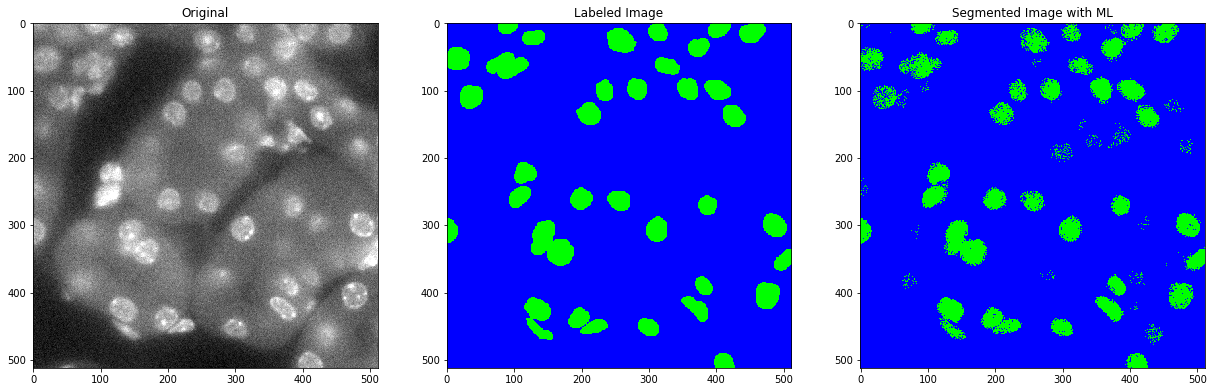

In [19]:
segmented_img = new_prediction.reshape((img_grayscale.shape))

fig = plt.figure(figsize=(21,7))
fig.add_subplot(1,3,1)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Original')

fig.add_subplot(1,3,2)
plt.imshow(labeled_img_grayscale, cmap='brg') 
plt.title('Labeled Image')

fig.add_subplot(1,3,3)
plt.imshow(segmented_img, cmap='brg') 
plt.title('Segmented Image with ML');

### Step 6: Use the model for batch segmentation

#### Define a function to automate feature extraction

In [20]:
def feature_extraction(input_img):
    df = pd.DataFrame()
    df['Original_pixels'] = input_img.reshape(-1)
    
    ### Gabor
    ksize = 5 
    phi = 0
    gabor_index = 0
    gabor_kernels = []

    for theta in range(2):
        theta = theta /4. * np.pi
        for sigma in (3,5):
            for lambd in np.arange(0, np.pi, np.pi /4.):
                for gamma in (0.05, 0.5):
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
                    gabor_kernels.append(kernel)
                    filtered_input_img = cv2.filter2D(input_img, cv2.CV_8UC3, kernel)
                    filtered_input_img_col = filtered_input_img.reshape(-1)
                    df[f'Gabor_{gabor_index}'] = filtered_input_img_col
                    gabor_index += 1

    ###Canny
    canny_min = np.arange(50,200,20)
    canny_max = np.arange(50,200,20)
    for min in canny_min:
        for max in canny_max:
            img_edges = cv2.Canny(input_img, min, max)
            img_edges_col = img_edges.reshape(-1)
            df[f'Canny_{min}_{max}'] = img_edges_col
            
    ###Various
    img_roberts = roberts(input_img)
    df['Roberts'] = img_roberts.reshape(-1)

    img_sobel = sobel(input_img)
    df['Sobel'] = img_sobel.reshape(-1)

    img_scharr = scharr(input_img)
    df['Scharr'] = img_scharr.reshape(-1)

    img_prewitt = prewitt(input_img)
    df['Prewitt'] = img_prewitt.reshape(-1)
    
    ###Gaussian
    for gauss_sigma in np.arange(1,20,2):
        gaussian_img = nd.gaussian_filter(input_img, gauss_sigma)
        df[f'Gaussian_{gauss_sigma}'] = gaussian_img.reshape(-1)
    
    ###Variance
    #for variance_size in np.arange(1,5,1):
    #    variance_img = nd.generic_filter(img_grayscale, np.var, size=variance_size)
    #    df[f'Variance_{variance_size}'] = variance_img.reshape(-1)
        
    ###Median
    for median_size in np.arange(1,10,2):
        median_img = nd.median_filter(input_img, size=median_size)
        df[f'Median_{median_size}'] = median_img.reshape(-1)
    
    return df

#### Batch process the folder

In [21]:
import glob
import os

filename = 'model_random_forest_01'
loaded_model = pickle.load(open(filename, 'rb'))

path = 'images/nuclei/series/*.tif'
count=0

for file in glob.glob(path):
    image_name = 'segmented_'+os.path.basename(file)

    current_img = cv2.imread(file)
    current_img_gray = cv2.cvtColor(current_img, cv2.COLOR_BGR2GRAY)
    
    X = feature_extraction(current_img_gray)
    current_result = loaded_model.predict(X)
    current_segmented = current_result.reshape((current_img_gray.shape))
    plt.imsave(f'images/nuclei/segmented/segmented_{image_name}', current_segmented, cmap='brg', format='tiff')